## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

err_count:3


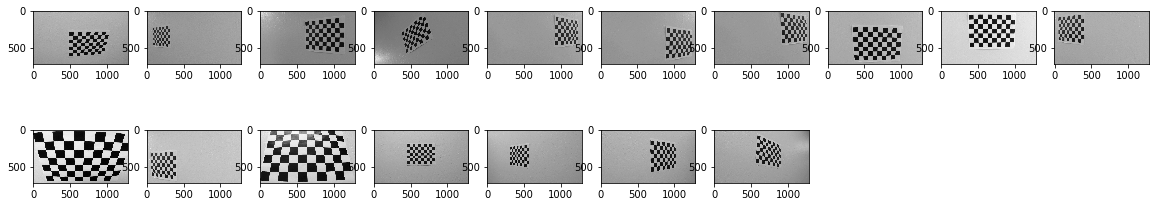

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

imgSize = (0,0)

# display calibration images
cols = 10
rows = 2
plt.figure(figsize=(cols * 2, rows * 2))
i = 0
err_count = 0


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        if imgSize == (0,0):
            imgSize = gray.shape[::-1]

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        plt.subplot(rows,cols,i+1)
        plt.imshow(gray.squeeze(), cmap="gray")
        i += 1
    else:
        err_count += 1

print("err_count:{}".format(err_count))

## Get Matrix and other variables from Camera Calibration

In [2]:
# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)

## Utility function to get an undistroted image based on camera calibraion

In [3]:
# get an undistorted image based on matrix from camera calibration
def get_undistorted_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

In [4]:
# utility to show two images side by side
# Plot the result
def plot2(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=40)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def plot3(image1, title1, image2, title2, plot3, title3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    ax3.plot(plot3)
    ax3.set_title(title3, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

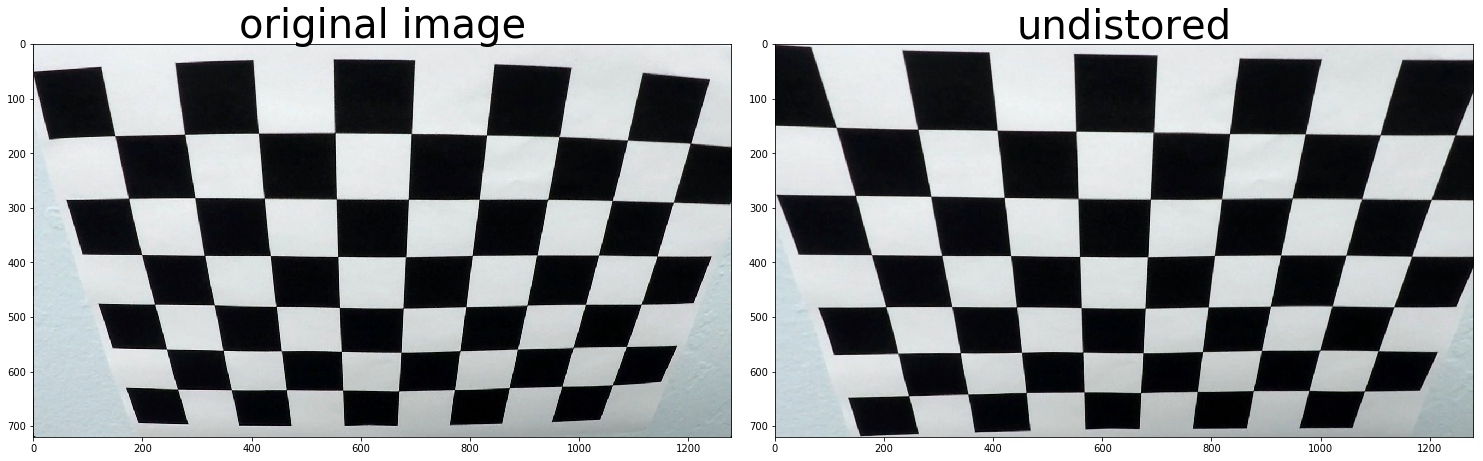

In [5]:
# Apply a distortion correction to raw images.
%matplotlib inline
# read a test image
test_file = 'camera_cal/calibration2.jpg'
img1 = cv2.imread(test_file)
dst1 = get_undistorted_image(img1)
plot2(img1, 'original image', dst1, 'undistored')

In [15]:
# apply color and sobel gradient 
def thresh(img, thresh_min, thresh_max):
        ret = np.zeros_like(img)
        ret[(img >= thresh_min) & (img <= thresh_max)] = 1
        return ret
        
def pipeline2(img1, ksize=3, sx_low=104, sx_high=255, mag_low=50, mag_high=255, dir_low=0, dir_high=np.pi/2, hls_low=57, hls_high=84, bright_low=40, bright_high=100, H_low=10, H_high=30, S_low=50, S_high=255, V_low=154, V_high=245, R_low=0, R_high=100):
    
    img = np.copy(img1)
    combined_binary = np.zeros((img.shape[0],img.shape[1]))

    # Convert to HSV color space for yellow and white lines
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    t_yellow_H = thresh(H,H_low,H_high)
    t_yellow_S = thresh(S,S_low,S_high)
    t_yellow_V = thresh(V,V_low,V_high)

    t_white_R = thresh(R,R_low,R_high)
    t_white_V = thresh(V,V_low,V_high)
    
    combined_binary[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    combined_binary[(t_white_R==1)|(t_white_V==1)] = 1
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    t_l_channel = thresh(l_channel, hls_low, hls_high)
    combined_binary[t_l_channel == 1] = 1
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   
    t_b_channel = thresh(b_channel, bright_low, bright_high)
    combined_binary[t_b_channel == 1] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    t_sobel_x = thresh(scaled_sobel,sx_low,sx_high)
    combined_binary[t_sobel_x == 1] = 1
    
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / np.max(mag)) 
    mag_binary = thresh(scaled_mag, mag_low, mag_high)
     
    # 5) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    theda = np.arctan2(abs_sobely, abs_sobelx)
    theda_binary = thresh(theda, dir_low, dir_high)
    
    combined_binary[((mag_binary == 1) & (theda_binary == 1))] = 1
    
    return combined_binary

In [104]:
# apply color and sobel gradient 
def pipeline(img1, s_thresh=(180, 255), sx_thresh=(80, 255), mag_thresh=(50,255), theda_thresh=(0, np.pi/2), l_thresh=(215,255), b_thresh=(145,200)):
    img = np.copy(img1)
    sobel_kernel=3
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / np.max(mag)) 
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
     
    # 5) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    theda = np.arctan2(abs_sobely, abs_sobelx)
    theda_binary = np.zeros_like(theda)
    theda_binary[(theda >= theda_thresh[0]) & (theda <= theda_thresh[1])] = 1
    
    # combine all
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (sx_binary == 1)  | ((mag_binary == 1) & (theda_binary == 1))] = 1
    
    return combined_binary

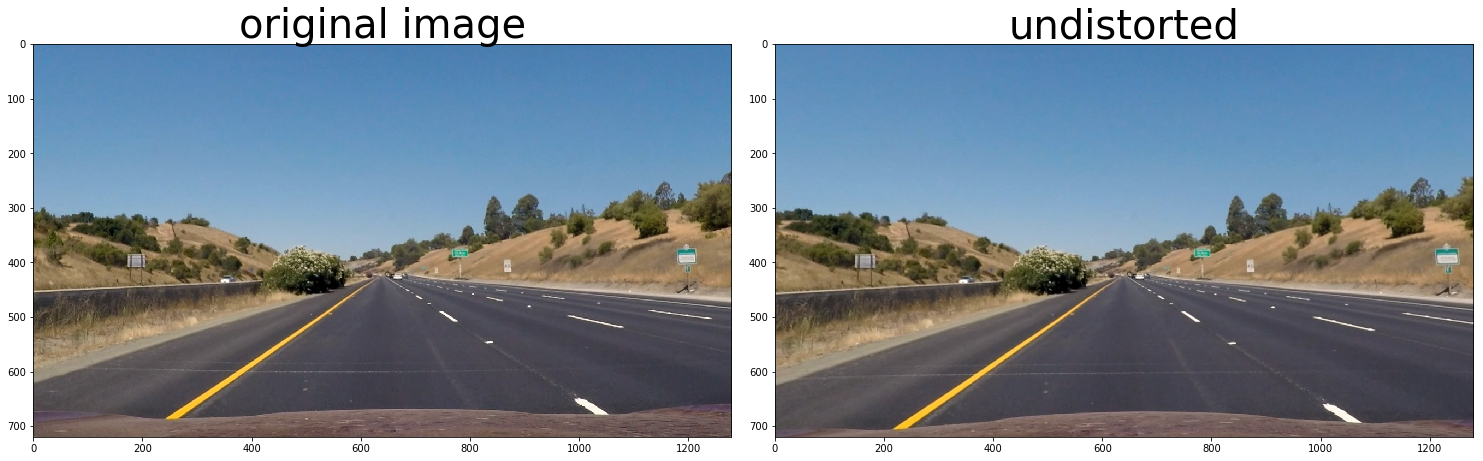

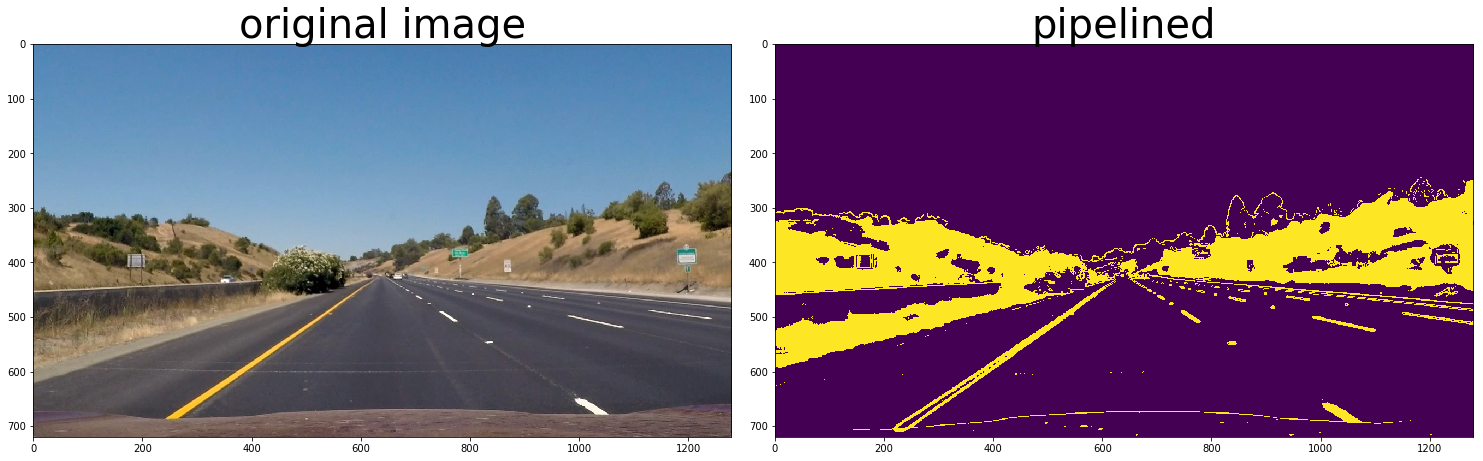

In [162]:
import matplotlib.image as mpimg
test_file = 'test_images/straight_lines1.jpg'
tst_img1 = mpimg.imread(test_file)
dst_img1 = get_undistorted_image(tst_img1)
output = pipeline(dst_img1)
plot2(tst_img1, 'original image', dst_img1, 'undistorted')
plot2(tst_img1, 'original image', output, 'pipelined')

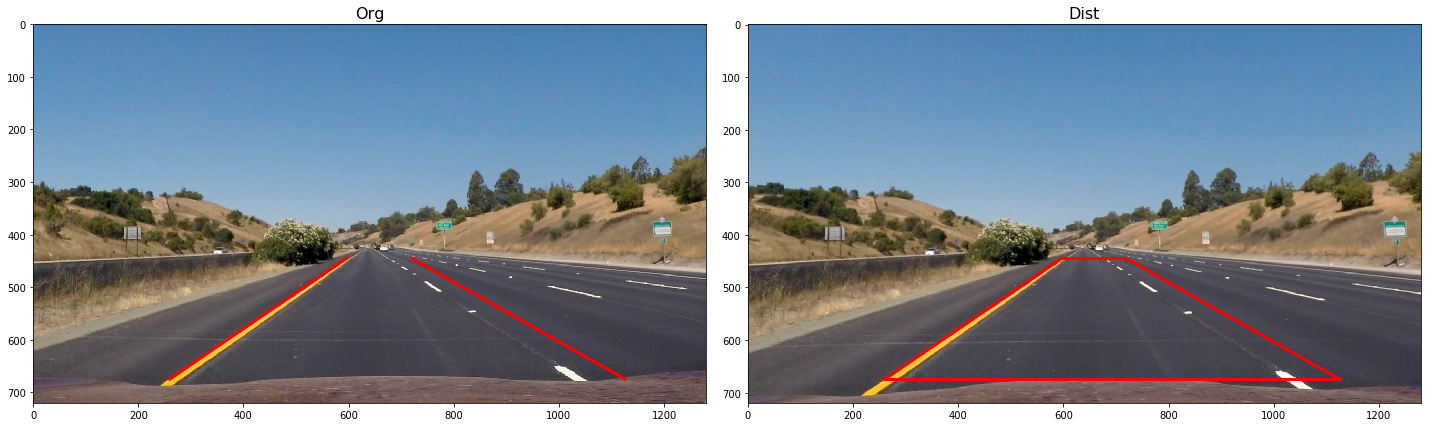

In [163]:
# test region 
f, (ax1, ax2) = plt.subplots(1,2,  figsize=(20, 9))
f.tight_layout()
ax1.imshow(tst_img1)
ax1.set_xlim(0, 1280)
ax1.set_ylim(0, 720)
#src_corners = np.float32([[585, 460], [203,  720], [1127, 720], [695, 460]])
#src_corners = np.float32([[596, 445], [260,  675], [1126, 675], [720, 445]])
fit_x = [260, 596]
fit_y = [675, 445]
ax1.plot(fit_x, fit_y, color='red', linewidth=3)
fit_x2 = [720,1126]
fit_y2 = [445, fit_y[0]]
ax1.plot(fit_x2, fit_y2, color='red', linewidth=3)
ax1.set_title('Org', fontsize=16)
ax1.invert_yaxis() # to visualize as we do the images
    
ax2.imshow(dst_img1)
ax2.set_title('Dist', fontsize=16)
ax2.plot(fit_x, fit_y, color='red', linewidth=3)
ax2.plot(fit_x2, fit_y2, color='red', linewidth=3)
fit_x3 = [fit_x[0],fit_x2[1]]
fit_y3 = [fit_y[0], fit_y2[1]]
ax2.plot(fit_x3, fit_y3, color='red', linewidth=3)
fit_x4 = [fit_x[1],fit_x2[0]]
fit_y4 = [fit_y[1], fit_y2[0]]
ax2.plot(fit_x4, fit_y4, color='red', linewidth=3)

In [100]:
# apply PerspectiveTransform
def apply_persepctive_transform(img, src_corners, dst_corners):
    width =  img.shape[1]
    height = img.shape[0]
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

(720, 1280)


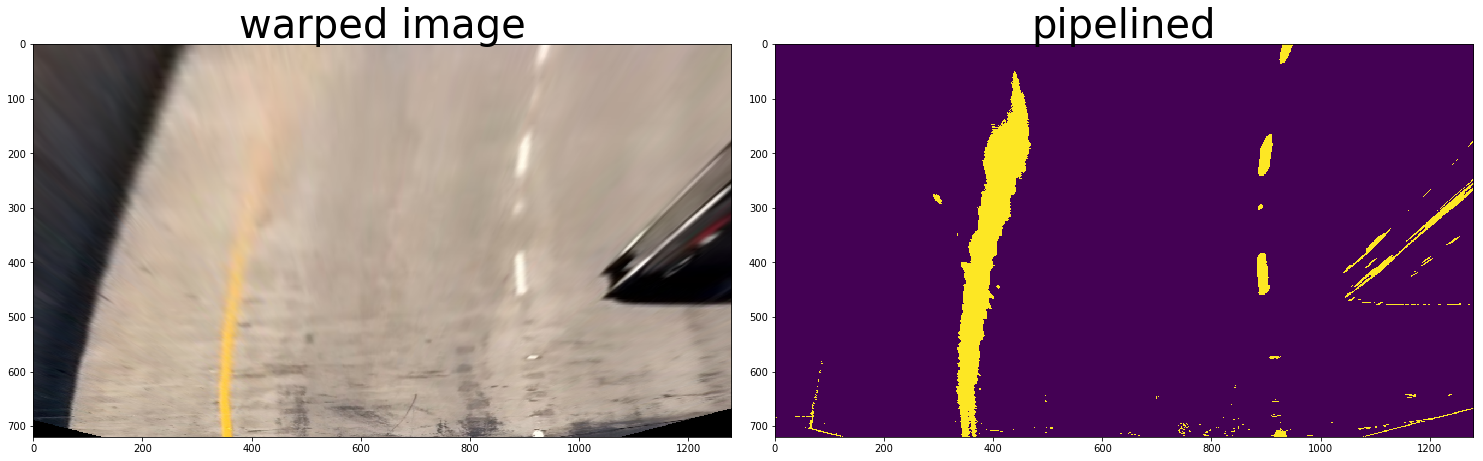

In [106]:
# test perspective transform
print(output.shape)
#src_corners = np.float32([[490, 482], [810,  482], [1250, 720], [40, 720]])
# update2 
#src_corners = np.float32([[585, 460], [203,  720], [1127, 720], [695, 460]])
#src_corners = np.float32([[598, 445], [198,  720], [1127, 720], [686, 445]])
#src_corners = np.float32([[598, 445], [264,  675], [1052, 675], [686, 445]])
src_corners = np.float32([[596, 445], [260,  675], [1126, 675], [720, 445]])
dst_corners = np.float32([[320, 0], [320,  720], [960, 720], [960, 0]])
warped_img = apply_persepctive_transform(dst_img1, src_corners, dst_corners)
output2 = pipeline(warped_img)
plot2(warped_img, 'warped image', output2, 'pipelined')

In [107]:
# uitility to tranform images from un-distorted, perspective tranform, and pipeline 
def apply_transforms(image):
    # 1. make the image undistored
    dst1 = get_undistorted_image(image)
    #src_corners = np.float32([[490, 480], [810,  480], [1250, 720], [40, 720]])
    # 2. apply perspective transform
    warped = apply_persepctive_transform(dst1, src_corners, dst_corners)
    # 3. apply pipeline with gradient and color threshold
    return pipeline(warped)

In [108]:
# uitility to tranform images from un-distorted, perspective tranform, and pipeline 
def apply_transforms_no_pipeline(image):
    # 1. make the image undistored
    dst1 = get_undistorted_image(image)
    #src_corners = np.float32([[490, 480], [810,  480], [1250, 720], [40, 720]])
    # 2. apply perspective transform
    warped = apply_persepctive_transform(dst1, src_corners, dst_corners)
    return warped

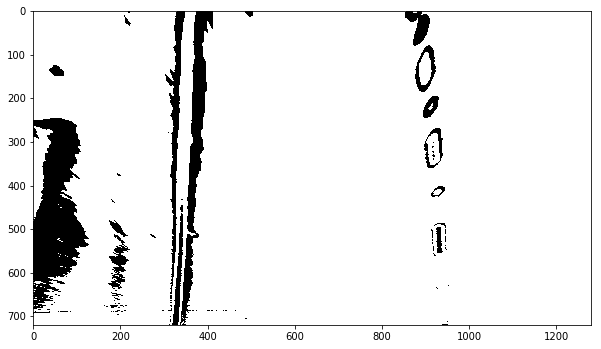

In [18]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

image = mpimg.imread('test_images/straight_lines1.jpg')
tst_image = apply_transforms_no_pipeline(image)
 
def interactive_mask(ksize, sx_low, sx_high, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, 
                     bright_low, bright_high, H_low, H_high, S_low, S_high, V_low, V_high, R_low, R_high):
    combined = pipeline(tst_image, ksize, sx_low, sx_high, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high, H_low, H_high, S_low, S_high, V_low, V_high, R_low, R_high)

    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')

interact(interactive_mask, ksize=(1,31,2), sx_low=(0,255), sx_high=(0,255), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255), \
         H_low=(0,255), H_high=(0,255), S_low=(0,255), S_high=(0,255), V_low=(0,255), V_high=(0,255), R_low=(0,255), R_high=(0,255))


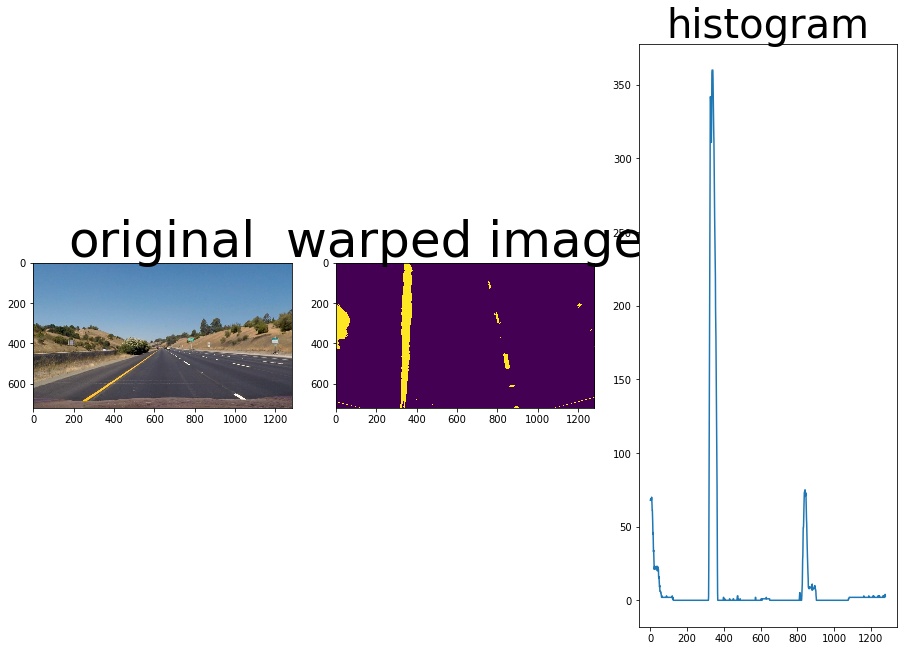

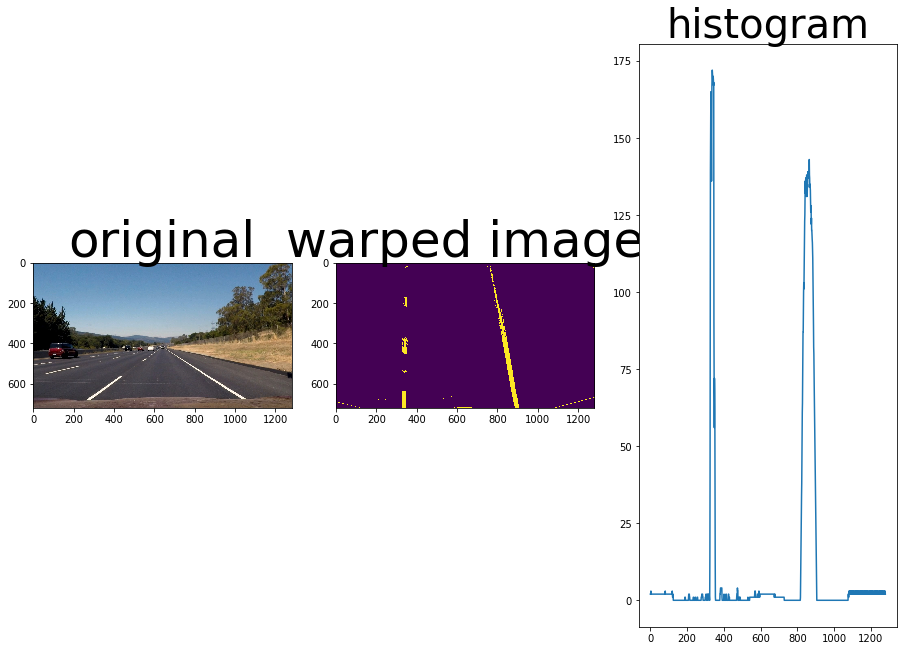

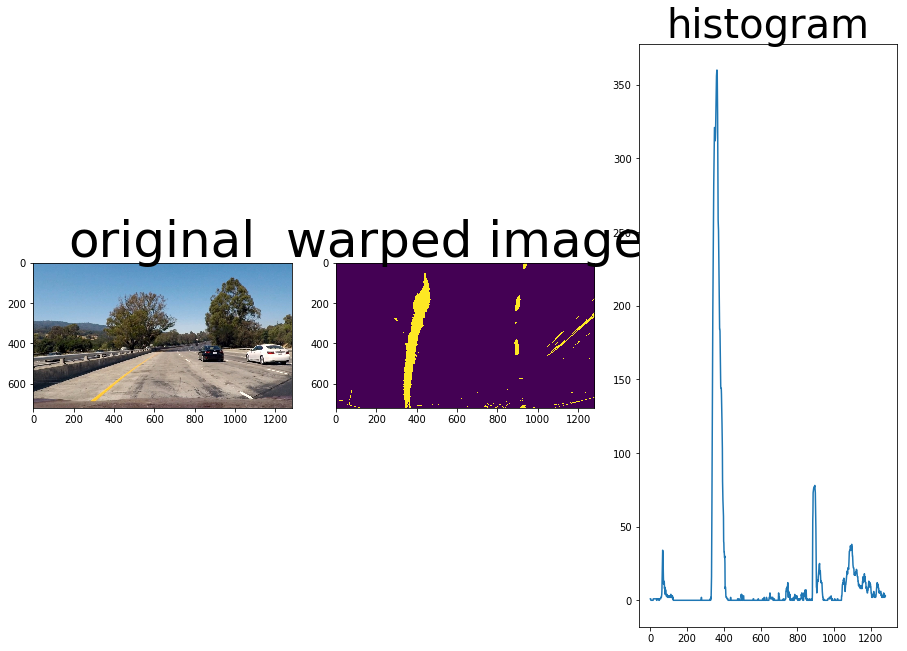

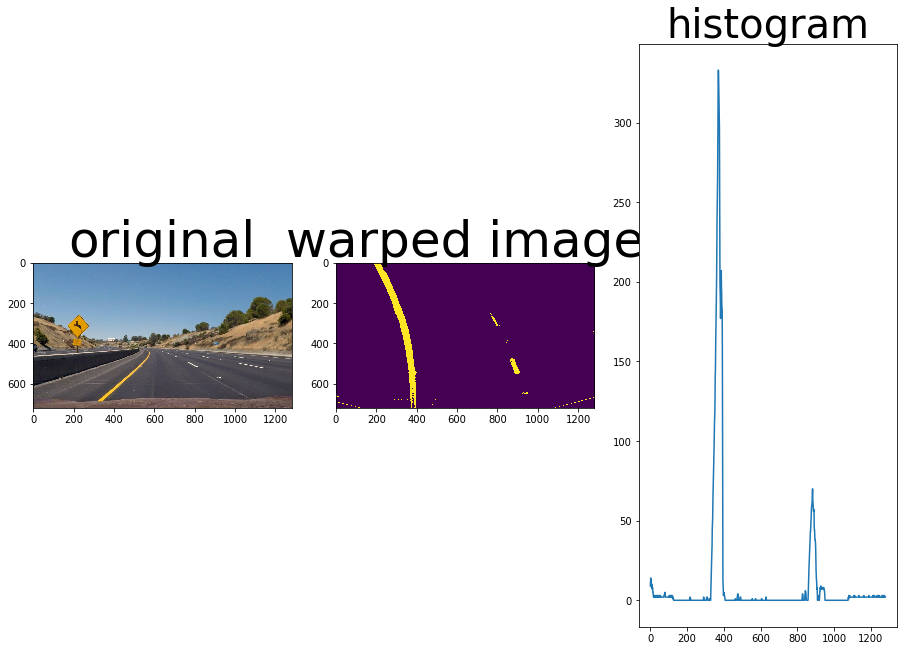

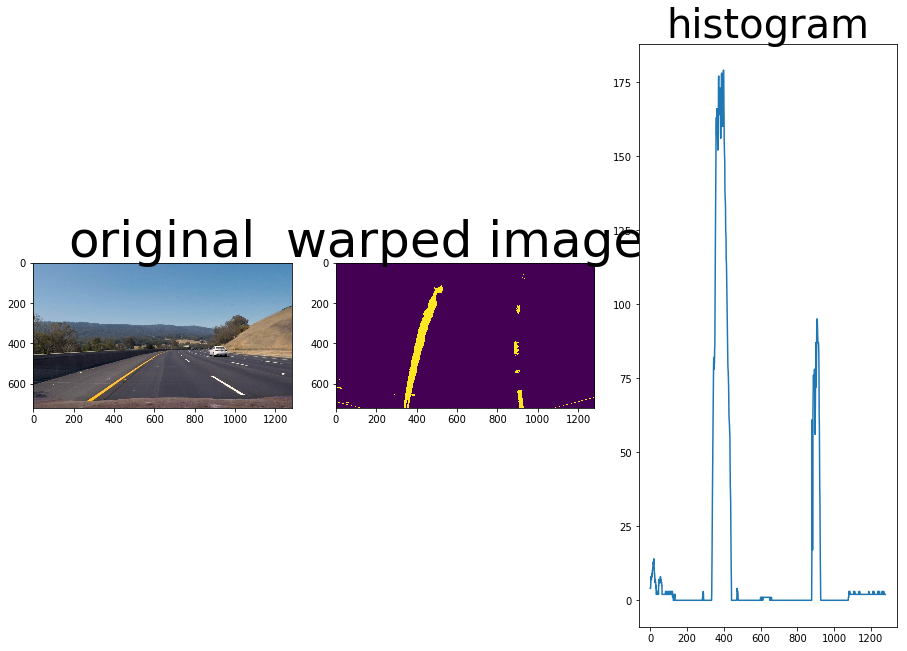

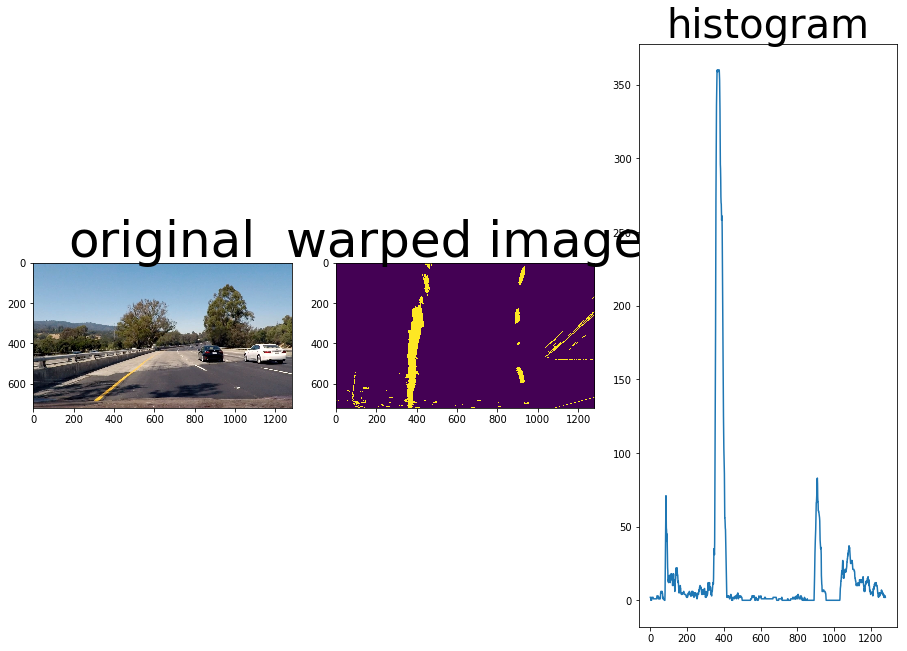

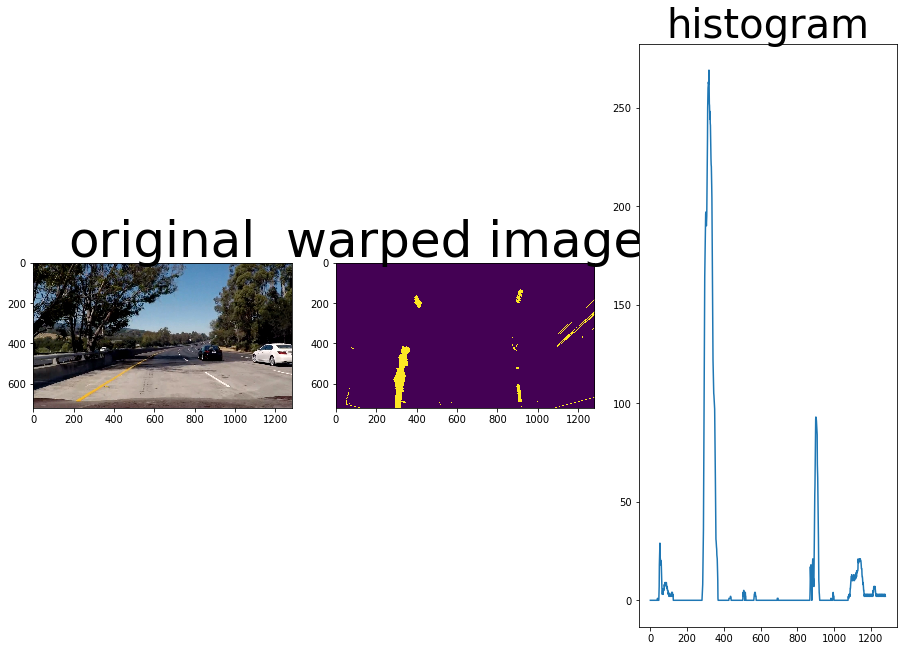

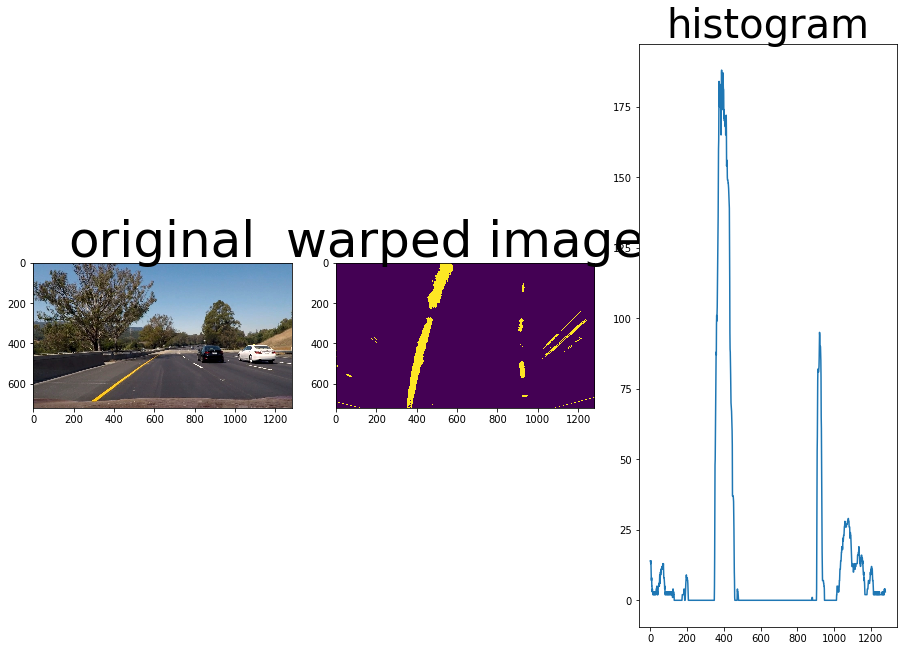

In [110]:
for image in glob.glob('test_images/*.jpg'):
    img1 = mpimg.imread(image)
    #warped = apply_transforms(img1)
    warped = apply_transforms(img1)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    plot3(img1, 'original', warped, 'warped image', histogram, 'histogram' )

In [111]:
# measuring curvature
def measure_curvature(leftx, lefty, rightx, righty):
    
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [173]:

# Fill lane for the image
def fill_lane (img1, plot=True, dbg_frame_idx=0):
    # apply transforms first
    warped = apply_transforms(img1)
    
    # use histogram to look for left and right lanes
    delta = 90
    sigma_gap = 90
    i = 720
    j = 630
    pivotx = 640
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    # global variables to keep track of prior left/right x
    global global_left_x
    global global_right_x

    x, y = np.nonzero(np.transpose(warped))
    #print("x len={}, y len={}".format(len(x), len(y)))
    dbg_count = 0
    dbg_list = []
    abs_peak_left = -1
    abs_peak_right = -1
    dbg_peak_left = [];
    dbg_peak_right = [];
    avg_peak_left = 0
    avg_peak_right = 0
    gap = 0
    hist_all = np.sum(warped[j:i,:], axis=0)
    prior_peak_left = np.argmax(hist_all[:pivotx]) 
    prior_peak_right = np.argmax(hist_all[pivotx:]) + pivotx
    if global_left_x > 0:
        dbg_peak_left.append(global_left_x)
        if (np.abs(global_left_x - prior_peak_left) < sigma_gap):
            dbg_peak_left.append(prior_peak_left)
    else:
        dbg_peak_left.append(prior_peak_left)
    if global_right_x > 0:
        dbg_peak_right.append(global_right_x)
        if (np.abs(global_right_x - prior_peak_right) < sigma_gap):
            dbg_peak_right.append(prior_peak_right)
    else:
        dbg_peak_right.append(prior_peak_right)
    #print("prior_peak_left:{}, prior_peak_right:{}".format(prior_peak_left, prior_peak_right))
    while j >= 0:
        hist = np.sum(warped[j:i,:], axis=0)
        peak_left = np.argmax(hist[:pivotx])
        sigma2 = max(np.std(dbg_peak_left)*2, sigma_gap)
        mean = np.mean(dbg_peak_left)
        if (np.abs(peak_left - mean) < sigma2):
            dbg_peak_left.append(peak_left)
            if abs_peak_left == -1:
                abs_peak_left = peak_left
            dbg_peak_left.append(peak_left)
            x_idx = np.where((x > (peak_left - 25)) & (x < (peak_left + 25)) & (y > j) & (y < i))
            if np.sum(x[x_idx]) != 0:
                leftx.extend(x[x_idx].tolist())
                lefty.extend(y[x_idx].tolist())
            prior_peak_left = peak_left
            
        peak_right = np.argmax(hist[pivotx:]) + pivotx
        sigma2 = max(np.std(dbg_peak_right)*2, sigma_gap)
        mean = np.mean(dbg_peak_right)
        if (np.abs(peak_right - mean) < sigma2):
            dbg_peak_right.append(peak_right)
            if (abs_peak_right == -1):
                abs_peak_right = peak_right
            if (dbg_count < 5):
                dbg_list.append(peak_right)
                dbg_count += 1
            x_idx = np.where((x > (peak_right - 25)) & (x < (peak_right + 25)) & (y > j) & (y < i))
            if np.sum(x[x_idx]) != 0:
                rightx.extend(x[x_idx].tolist())
                righty.extend(y[x_idx].tolist())
            prior_peak_right = peak_right
        #else:
        #    print("Outliner peak_right:{}, signma2:{}, mean:{}".format(peak_right, sigma2, mean))
        i -= delta
        j -= delta
    
    # check valid data points to proceed
    if len(leftx) == 0 or len(rightx) == 0:
        print("Got dbg_frame_idx:{}, len(leftx):{}, len(rightx):{}".format(dbg_frame_idx, len(leftx), len(rightx)))
        name = "dbg_frame_" + str(dbg_frame_idx) + ".jpg"
        cv2.imwrite(name, img1)
        dbg_frame_idx += 1
        return img1
    
    #print("peak_right:{}".format(peak_right))    
    leftx = np.array(leftx).astype(np.float32)
    lefty = np.array(lefty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)   
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_x = left_fit[0] * lefty**2 + left_fit[1] * lefty + left_fit[2]
    #leftx_int = left_fit[0] * 720**2 + left_fit[1] * 720 + left_fit[2]
    leftx_int = abs_peak_left
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    leftx = leftx[lsort]
    lefty = lefty[lsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_x = left_fit[0] * lefty**2 + left_fit[1] * lefty + left_fit[2]
    global_left_x = leftx_int
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_x = right_fit[0] * righty**2 + right_fit[1] * righty + right_fit[2]
    #rightx_int = right_fit[0] * 720**2 + right_fit[1]*720 + right_fit[2]
    rightx_int = abs_peak_right
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_fit[2])
    righty = np.append(righty, 0)
    rsort = np.argsort(righty)
    rightx = rightx[rsort]
    righty = righty[rsort]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_x = right_fit[0] * righty**2 + right_fit[1] * righty + right_fit[2]
    #print("peak_right:{}, rightx_int:{}, peak_left:{}, leftx_int:{}".format(peak_right, rightx_int, peak_left, leftx_int))
    global_right_x = rightx_int
    
    # calculate vehicle pos
    pos = (rightx_int+leftx_int)/2
    distance_from_center = abs((pivotx - pos)*3.7/700) 
    img_size = (warped.shape[1], warped.shape[0])
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fit_x, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fit_x, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness=35)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    M2 = cv2.getPerspectiveTransform(dst_corners, src_corners)
    newWarp = cv2.warpPerspective(color_warp, M2, img_size)
    result = cv2.addWeighted(img1, 1, newWarp, 0.5, 0)
    
    # calculate curvatures
    left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)
    if plot:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        #ax1.imshow(apply_transforms_no_pipeline(img1))
        ax1.imshow(apply_transforms(img1))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fit_x, lefty, color='green', linewidth=5)
        ax1.plot(right_fit_x, righty, color='red', linewidth=5)
        ax1.set_title('Lane Lines', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images
        # Print radius of curvature on image/video
        cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        ax2.imshow(result)
        ax2.set_title('Lane Fill', fontsize=16)
    else:
        if pos > 640:
            cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        else:
            cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
         
    return result

global_right_x:896, global_left_x:373
global_right_x:896, global_left_x:373


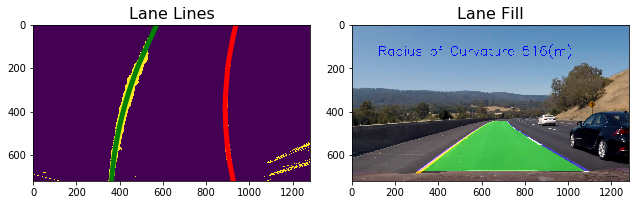

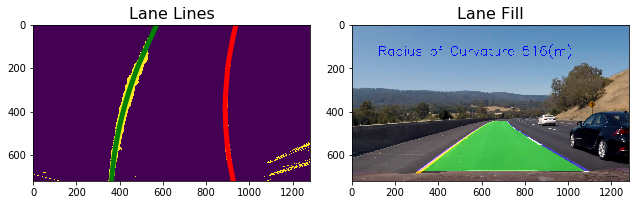

In [174]:
global_left_x = 0
global_right_x = 930
#for image in glob.glob('test_images/*.jpg'):
#    img1 = mpimg.imread(image)
#    fill_lane(img1)
    
t_img1 = mpimg.imread('test_images/dbg2/test_721.jpg')
fill_lane(t_img1)
print("global_right_x:{}, global_left_x:{}".format(global_right_x, global_left_x))
t_img2 = mpimg.imread('test_images/dbg2/test_721.jpg')
fill_lane(t_img2)
print("global_right_x:{}, global_left_x:{}".format(global_right_x, global_left_x))
#t_img3 = mpimg.imread('test_images/test1.jpg')
#fill_lane(t_img3)

In [175]:
def process_vid2(image):
    global dbg_frame_idx
    #if (dbg_frame_idx % 5) == 1:
    #    img2save = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #    cv2.imwrite("test_images/dbg/test_"+str(dbg_frame_idx)+".jpg", img2save)
    result = fill_lane(image, False, dbg_frame_idx)
    dbg_frame_idx += 1
    return result

In [176]:
video_output = 'output_images/result_project_video.mp4'
dbg_frame_idx = 1
global_left_x = 0
global_right_x = 0
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/result_project_video.mp4
[MoviePy] Writing video output_images/result_project_video.mp4


100%|█████████▉| 1260/1261 [05:16<00:00,  3.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_project_video.mp4 



In [177]:
video_output = 'output_images/result_challenge_video.mp4'
dbg_frame_idx = 101
clip1 = VideoFileClip('challenge_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/result_challenge_video.mp4
[MoviePy] Writing video output_images/result_challenge_video.mp4


 27%|██▋       | 130/485 [00:21<00:58,  6.03it/s]

Got dbg_frame_idx:230, len(leftx):0, len(rightx):1137
Got dbg_frame_idx:231, len(leftx):0, len(rightx):923


 27%|██▋       | 131/485 [00:22<00:59,  5.95it/s]

Got dbg_frame_idx:232, len(leftx):0, len(rightx):664
Got dbg_frame_idx:233, len(leftx):0, len(rightx):387


 28%|██▊       | 134/485 [00:22<00:58,  5.95it/s]

Got dbg_frame_idx:234, len(leftx):0, len(rightx):180


 96%|█████████▋| 467/485 [01:22<00:03,  5.56it/s]

Got dbg_frame_idx:567, len(leftx):6387, len(rightx):0


 97%|█████████▋| 469/485 [01:22<00:03,  5.25it/s]

Got dbg_frame_idx:570, len(leftx):5854, len(rightx):0


 99%|█████████▉| 479/485 [01:24<00:01,  5.53it/s]

Got dbg_frame_idx:580, len(leftx):5196, len(rightx):0
Got dbg_frame_idx:581, len(leftx):5107, len(rightx):0


 99%|█████████▉| 481/485 [01:25<00:00,  5.65it/s]

Got dbg_frame_idx:582, len(leftx):5291, len(rightx):0
Got dbg_frame_idx:583, len(leftx):4913, len(rightx):0


100%|██████████| 485/485 [01:25<00:00,  5.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_challenge_video.mp4 



In [178]:
def process_vid_dbg(image):
    global dbg_frame_idx
    #if (dbg_frame_idx % 10) == 1:
    #    cv2.imwrite("dbg2/test_"+str(dbg_frame_idx)+".jpg", image)
    result = fill_lane(image, False)
    dbg_frame_idx += 1
    return result

In [179]:
video_output = 'output_images/result_harder_challenge_video.mp4'
dbg_frame_idx = 1001
clip1 = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/result_harder_challenge_video.mp4
[MoviePy] Writing video output_images/result_harder_challenge_video.mp4


  2%|▏         | 23/1200 [00:05<04:48,  4.08it/s]

Got dbg_frame_idx:1024, len(leftx):0, len(rightx):11360
Got dbg_frame_idx:1025, len(leftx):0, len(rightx):11599


  2%|▏         | 25/1200 [00:06<04:29,  4.36it/s]

Got dbg_frame_idx:1026, len(leftx):0, len(rightx):11466


  5%|▍         | 56/1200 [00:14<04:05,  4.65it/s]

Got dbg_frame_idx:1057, len(leftx):0, len(rightx):11748
Got dbg_frame_idx:1058, len(leftx):0, len(rightx):11221


  5%|▍         | 58/1200 [00:14<03:53,  4.89it/s]

Got dbg_frame_idx:1059, len(leftx):0, len(rightx):14869
Got dbg_frame_idx:1060, len(leftx):0, len(rightx):18750

  5%|▌         | 60/1200 [00:14<03:49,  4.96it/s]


Got dbg_frame_idx:1061, len(leftx):0, len(rightx):14648


  6%|▌         | 67/1200 [00:16<04:04,  4.64it/s]

Got dbg_frame_idx:1068, len(leftx):0, len(rightx):7931
Got dbg_frame_idx:1069, len(leftx):0, len(rightx):8170


  7%|▋         | 80/1200 [00:19<04:02,  4.61it/s]

Got dbg_frame_idx:1081, len(leftx):0, len(rightx):10657
Got dbg_frame_idx:1082, len(leftx):0, len(rightx):10121


  7%|▋         | 82/1200 [00:19<03:40,  5.07it/s]

Got dbg_frame_idx:1083, len(leftx):0, len(rightx):11246


  8%|▊         | 97/1200 [00:22<03:32,  5.19it/s]

Got dbg_frame_idx:1098, len(leftx):596, len(rightx):0


  8%|▊         | 98/1200 [00:23<03:38,  5.03it/s]

Got dbg_frame_idx:1099, len(leftx):41, len(rightx):0


  8%|▊         | 99/1200 [00:23<03:40,  4.98it/s]

Got dbg_frame_idx:1100, len(leftx):244, len(rightx):0
Got dbg_frame_idx:1101, len(leftx):372, len(rightx):0


  8%|▊         | 101/1200 [00:23<03:31,  5.21it/s]

Got dbg_frame_idx:1102, len(leftx):281, len(rightx):0
Got dbg_frame_idx:1103, len(leftx):0, len(rightx):3606


  9%|▉         | 108/1200 [00:24<03:26,  5.29it/s]

Got dbg_frame_idx:1109, len(leftx):0, len(rightx):4838
Got dbg_frame_idx:1110, len(leftx):0, len(rightx):4708


  9%|▉         | 110/1200 [00:25<03:35,  5.05it/s]

Got dbg_frame_idx:1111, len(leftx):0, len(rightx):6475
Got dbg_frame_idx:1112, len(leftx):0, len(rightx):7072


  9%|▉         | 112/1200 [00:25<03:28,  5.22it/s]

Got dbg_frame_idx:1113, len(leftx):0, len(rightx):6042
Got dbg_frame_idx:1114, len(leftx):0, len(rightx):7141


 10%|▉         | 114/1200 [00:26<03:23,  5.33it/s]

Got dbg_frame_idx:1115, len(leftx):0, len(rightx):3148
Got dbg_frame_idx:1116, len(leftx):0, len(rightx):4369


 10%|▉         | 116/1200 [00:26<03:31,  5.13it/s]

Got dbg_frame_idx:1117, len(leftx):0, len(rightx):4555
Got dbg_frame_idx:1118, len(leftx):0, len(rightx):4080


 11%|█         | 127/1200 [00:28<03:42,  4.81it/s]

Got dbg_frame_idx:1128, len(leftx):10787, len(rightx):0
Got dbg_frame_idx:1129, len(leftx):11073, len(rightx):0


 11%|█         | 129/1200 [00:29<03:25,  5.20it/s]

Got dbg_frame_idx:1130, len(leftx):10796, len(rightx):0
Got dbg_frame_idx:1131, len(leftx):8139, len(rightx):0


 11%|█         | 131/1200 [00:29<03:20,  5.32it/s]

Got dbg_frame_idx:1132, len(leftx):8513, len(rightx):0


 11%|█         | 133/1200 [00:29<03:23,  5.24it/s]

Got dbg_frame_idx:1134, len(leftx):8273, len(rightx):0
Got dbg_frame_idx:1135, len(leftx):8623, len(rightx):0


 11%|█▏        | 135/1200 [00:30<03:16,  5.42it/s]

Got dbg_frame_idx:1136, len(leftx):8835, len(rightx):0
Got dbg_frame_idx:1137, len(leftx):8497, len(rightx):0


 12%|█▏        | 138/1200 [00:30<03:10,  5.59it/s]

Got dbg_frame_idx:1138, len(leftx):8327, len(rightx):0
Got dbg_frame_idx:1139, len(leftx):6047, len(rightx):0


 12%|█▏        | 139/1200 [00:30<03:06,  5.70it/s]

Got dbg_frame_idx:1140, len(leftx):5695, len(rightx):0


 14%|█▎        | 163/1200 [00:35<03:00,  5.75it/s]

Got dbg_frame_idx:1164, len(leftx):2297, len(rightx):0
Got dbg_frame_idx:1165, len(leftx):2335, len(rightx):0


 16%|█▌        | 188/1200 [00:39<02:56,  5.73it/s]

Got dbg_frame_idx:1189, len(leftx):0, len(rightx):6493
Got dbg_frame_idx:1190, len(leftx):0, len(rightx):4085


 16%|█▌        | 190/1200 [00:40<03:02,  5.54it/s]

Got dbg_frame_idx:1191, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1192, len(leftx):0, len(rightx):327


 17%|█▋        | 204/1200 [00:43<03:44,  4.44it/s]

Got dbg_frame_idx:1205, len(leftx):15341, len(rightx):0
Got dbg_frame_idx:1206, len(leftx):18626, len(rightx):0


 21%|██        | 249/1200 [00:54<03:34,  4.42it/s]

Got dbg_frame_idx:1250, len(leftx):8462, len(rightx):0


 21%|██        | 250/1200 [00:55<03:30,  4.52it/s]

Got dbg_frame_idx:1251, len(leftx):6468, len(rightx):0


 21%|██        | 251/1200 [00:55<03:27,  4.56it/s]

Got dbg_frame_idx:1252, len(leftx):6601, len(rightx):0
Got dbg_frame_idx:1253, len(leftx):12421, len(rightx):0


 21%|██        | 253/1200 [00:55<03:20,  4.73it/s]

Got dbg_frame_idx:1254, len(leftx):12259, len(rightx):0


 24%|██▍       | 291/1200 [01:04<02:52,  5.26it/s]

Got dbg_frame_idx:1292, len(leftx):4710, len(rightx):0


 25%|██▍       | 295/1200 [01:05<02:48,  5.37it/s]

Got dbg_frame_idx:1296, len(leftx):6410, len(rightx):0


 25%|██▍       | 297/1200 [01:05<02:44,  5.49it/s]

Got dbg_frame_idx:1298, len(leftx):6081, len(rightx):0


 26%|██▌       | 308/1200 [01:07<02:46,  5.36it/s]

Got dbg_frame_idx:1309, len(leftx):5816, len(rightx):0
Got dbg_frame_idx:1310, len(leftx):5396, len(rightx):0


 26%|██▌       | 310/1200 [01:08<02:39,  5.56it/s]

Got dbg_frame_idx:1311, len(leftx):4642, len(rightx):0
Got dbg_frame_idx:1312, len(leftx):5896, len(rightx):0


 26%|██▌       | 312/1200 [01:08<02:34,  5.73it/s]

Got dbg_frame_idx:1313, len(leftx):5339, len(rightx):0
Got dbg_frame_idx:1314, len(leftx):4886, len(rightx):0


 26%|██▌       | 314/1200 [01:08<02:33,  5.79it/s]

Got dbg_frame_idx:1315, len(leftx):737, len(rightx):0


 29%|██▉       | 347/1200 [01:15<03:11,  4.46it/s]

Got dbg_frame_idx:1348, len(leftx):0, len(rightx):7556


 39%|███▉      | 470/1200 [01:44<02:31,  4.82it/s]

Got dbg_frame_idx:1471, len(leftx):6126, len(rightx):0


 39%|███▉      | 471/1200 [01:45<02:31,  4.80it/s]

Got dbg_frame_idx:1472, len(leftx):6178, len(rightx):0
Got dbg_frame_idx:1473, len(leftx):6398, len(rightx):0


 39%|███▉      | 473/1200 [01:45<02:23,  5.07it/s]

Got dbg_frame_idx:1474, len(leftx):5593, len(rightx):0
Got dbg_frame_idx:1475, len(leftx):6518, len(rightx):0


 40%|███▉      | 475/1200 [01:45<02:17,  5.27it/s]

Got dbg_frame_idx:1476, len(leftx):6273, len(rightx):0


 40%|███▉      | 478/1200 [01:46<02:14,  5.38it/s]

Got dbg_frame_idx:1479, len(leftx):2482, len(rightx):0
Got dbg_frame_idx:1480, len(leftx):2524, len(rightx):0


 40%|████      | 480/1200 [01:46<02:12,  5.42it/s]

Got dbg_frame_idx:1481, len(leftx):4205, len(rightx):0
Got dbg_frame_idx:1482, len(leftx):2620, len(rightx):0


 40%|████      | 482/1200 [01:47<02:08,  5.57it/s]

Got dbg_frame_idx:1483, len(leftx):3101, len(rightx):0


 41%|████      | 487/1200 [01:48<02:17,  5.20it/s]

Got dbg_frame_idx:1488, len(leftx):3842, len(rightx):0
Got dbg_frame_idx:1489, len(leftx):3015, len(rightx):0


 41%|████      | 489/1200 [01:48<02:12,  5.38it/s]

Got dbg_frame_idx:1490, len(leftx):2900, len(rightx):0


 45%|████▌     | 545/1200 [02:01<02:06,  5.20it/s]

Got dbg_frame_idx:1546, len(leftx):7040, len(rightx):0
Got dbg_frame_idx:1547, len(leftx):6599, len(rightx):0


 46%|████▌     | 548/1200 [02:01<01:55,  5.64it/s]

Got dbg_frame_idx:1548, len(leftx):6341, len(rightx):0
Got dbg_frame_idx:1549, len(leftx):6192, len(rightx):0


 46%|████▌     | 550/1200 [02:01<01:52,  5.77it/s]

Got dbg_frame_idx:1550, len(leftx):6789, len(rightx):0
Got dbg_frame_idx:1551, len(leftx):6817, len(rightx):0


 46%|████▌     | 551/1200 [02:02<01:51,  5.81it/s]

Got dbg_frame_idx:1552, len(leftx):6300, len(rightx):0
Got dbg_frame_idx:1553, len(leftx):6418, len(rightx):0


 46%|████▌     | 554/1200 [02:02<01:49,  5.90it/s]

Got dbg_frame_idx:1554, len(leftx):6605, len(rightx):0
Got dbg_frame_idx:1555, len(leftx):5940, len(rightx):0


 46%|████▋     | 556/1200 [02:03<01:50,  5.81it/s]

Got dbg_frame_idx:1556, len(leftx):5296, len(rightx):0
Got dbg_frame_idx:1557, len(leftx):5312, len(rightx):0


 46%|████▋     | 558/1200 [02:03<01:48,  5.89it/s]

Got dbg_frame_idx:1558, len(leftx):5149, len(rightx):0
Got dbg_frame_idx:1559, len(leftx):4360, len(rightx):0


 47%|████▋     | 559/1200 [02:03<01:48,  5.90it/s]

Got dbg_frame_idx:1560, len(leftx):4012, len(rightx):0
Got dbg_frame_idx:1561, len(leftx):3305, len(rightx):0


 47%|████▋     | 561/1200 [02:03<01:50,  5.79it/s]

Got dbg_frame_idx:1562, len(leftx):3225, len(rightx):0
Got dbg_frame_idx:1563, len(leftx):2948, len(rightx):0


 47%|████▋     | 564/1200 [02:04<01:48,  5.86it/s]

Got dbg_frame_idx:1564, len(leftx):2674, len(rightx):0
Got dbg_frame_idx:1565, len(leftx):2235, len(rightx):0


 47%|████▋     | 565/1200 [02:04<01:48,  5.85it/s]

Got dbg_frame_idx:1566, len(leftx):1872, len(rightx):0
Got dbg_frame_idx:1567, len(leftx):1918, len(rightx):0


 47%|████▋     | 567/1200 [02:04<01:48,  5.85it/s]

Got dbg_frame_idx:1568, len(leftx):1176, len(rightx):0
Got dbg_frame_idx:1569, len(leftx):1023, len(rightx):0


 48%|████▊     | 570/1200 [02:05<01:45,  5.97it/s]

Got dbg_frame_idx:1570, len(leftx):1118, len(rightx):0
Got dbg_frame_idx:1571, len(leftx):739, len(rightx):0


 48%|████▊     | 571/1200 [02:05<01:46,  5.93it/s]

Got dbg_frame_idx:1572, len(leftx):611, len(rightx):0
Got dbg_frame_idx:1573, len(leftx):575, len(rightx):0


 48%|████▊     | 574/1200 [02:06<01:45,  5.91it/s]

Got dbg_frame_idx:1574, len(leftx):571, len(rightx):0
Got dbg_frame_idx:1575, len(leftx):365, len(rightx):0


 48%|████▊     | 576/1200 [02:06<01:44,  5.96it/s]

Got dbg_frame_idx:1576, len(leftx):400, len(rightx):0
Got dbg_frame_idx:1577, len(leftx):425, len(rightx):0


 48%|████▊     | 578/1200 [02:06<01:43,  5.99it/s]

Got dbg_frame_idx:1578, len(leftx):375, len(rightx):0
Got dbg_frame_idx:1579, len(leftx):0, len(rightx):0


 48%|████▊     | 579/1200 [02:06<01:43,  5.99it/s]

Got dbg_frame_idx:1580, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1581, len(leftx):0, len(rightx):2


 48%|████▊     | 582/1200 [02:07<01:43,  5.96it/s]

Got dbg_frame_idx:1582, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1583, len(leftx):0, len(rightx):0


 49%|████▊     | 584/1200 [02:07<01:43,  5.93it/s]

Got dbg_frame_idx:1584, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1585, len(leftx):0, len(rightx):0


 49%|████▉     | 586/1200 [02:08<01:43,  5.94it/s]

Got dbg_frame_idx:1586, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1587, len(leftx):281, len(rightx):0


 49%|████▉     | 588/1200 [02:08<01:42,  6.00it/s]

Got dbg_frame_idx:1588, len(leftx):213, len(rightx):0
Got dbg_frame_idx:1589, len(leftx):294, len(rightx):0


 49%|████▉     | 590/1200 [02:08<01:44,  5.84it/s]

Got dbg_frame_idx:1590, len(leftx):300, len(rightx):0


 50%|████▉     | 595/1200 [02:09<01:41,  5.97it/s]

Got dbg_frame_idx:1595, len(leftx):0, len(rightx):1222
Got dbg_frame_idx:1596, len(leftx):0, len(rightx):645


 50%|████▉     | 597/1200 [02:09<01:40,  6.01it/s]

Got dbg_frame_idx:1597, len(leftx):0, len(rightx):379
Got dbg_frame_idx:1598, len(leftx):0, len(rightx):64


 50%|████▉     | 599/1200 [02:10<01:42,  5.88it/s]

Got dbg_frame_idx:1599, len(leftx):0, len(rightx):163
Got dbg_frame_idx:1600, len(leftx):0, len(rightx):9


 50%|█████     | 601/1200 [02:10<01:41,  5.88it/s]

Got dbg_frame_idx:1601, len(leftx):0, len(rightx):0


 50%|█████     | 603/1200 [02:10<01:40,  5.94it/s]

Got dbg_frame_idx:1603, len(leftx):855, len(rightx):0


 50%|█████     | 606/1200 [02:11<01:42,  5.81it/s]

Got dbg_frame_idx:1606, len(leftx):0, len(rightx):3264
Got dbg_frame_idx:1607, len(leftx):686, len(rightx):0


 51%|█████     | 607/1200 [02:11<01:47,  5.53it/s]

Got dbg_frame_idx:1608, len(leftx):939, len(rightx):0
Got dbg_frame_idx:1609, len(leftx):1202, len(rightx):0


 51%|█████     | 611/1200 [02:12<01:47,  5.46it/s]

Got dbg_frame_idx:1612, len(leftx):3757, len(rightx):0
Got dbg_frame_idx:1613, len(leftx):4819, len(rightx):0


 51%|█████     | 613/1200 [02:12<01:45,  5.55it/s]

Got dbg_frame_idx:1614, len(leftx):6588, len(rightx):0
Got dbg_frame_idx:1615, len(leftx):7539, len(rightx):0


 56%|█████▋    | 675/1200 [02:28<01:51,  4.71it/s]

Got dbg_frame_idx:1676, len(leftx):0, len(rightx):1862


 57%|█████▋    | 687/1200 [02:30<01:38,  5.19it/s]

Got dbg_frame_idx:1687, len(leftx):0, len(rightx):3795
Got dbg_frame_idx:1688, len(leftx):0, len(rightx):88


 58%|█████▊    | 694/1200 [02:32<01:35,  5.30it/s]

Got dbg_frame_idx:1695, len(leftx):0, len(rightx):4836
Got dbg_frame_idx:1696, len(leftx):0, len(rightx):5200


 58%|█████▊    | 697/1200 [02:32<01:31,  5.49it/s]

Got dbg_frame_idx:1697, len(leftx):0, len(rightx):5382
Got dbg_frame_idx:1698, len(leftx):0, len(rightx):5305


 58%|█████▊    | 698/1200 [02:32<01:30,  5.56it/s]

Got dbg_frame_idx:1699, len(leftx):0, len(rightx):3720
Got dbg_frame_idx:1700, len(leftx):0, len(rightx):4240


 58%|█████▊    | 700/1200 [02:33<01:28,  5.66it/s]

Got dbg_frame_idx:1701, len(leftx):0, len(rightx):4479
Got dbg_frame_idx:1702, len(leftx):0, len(rightx):4868


 58%|█████▊    | 702/1200 [02:33<01:28,  5.60it/s]

Got dbg_frame_idx:1703, len(leftx):0, len(rightx):5071


 59%|█████▉    | 705/1200 [02:34<01:28,  5.59it/s]

Got dbg_frame_idx:1705, len(leftx):0, len(rightx):3735


 59%|█████▉    | 708/1200 [02:34<01:28,  5.59it/s]

Got dbg_frame_idx:1709, len(leftx):0, len(rightx):5414


 65%|██████▍   | 777/1200 [02:49<01:25,  4.95it/s]

Got dbg_frame_idx:1778, len(leftx):4170, len(rightx):0


 67%|██████▋   | 808/1200 [02:56<01:16,  5.15it/s]

Got dbg_frame_idx:1809, len(leftx):6133, len(rightx):0
Got dbg_frame_idx:1810, len(leftx):5820, len(rightx):0


 68%|██████▊   | 810/1200 [02:56<01:12,  5.41it/s]

Got dbg_frame_idx:1811, len(leftx):4936, len(rightx):0


 71%|███████   | 847/1200 [03:04<01:16,  4.60it/s]

Got dbg_frame_idx:1848, len(leftx):4805, len(rightx):0


 72%|███████▏  | 862/1200 [03:08<01:12,  4.68it/s]

Got dbg_frame_idx:1863, len(leftx):7631, len(rightx):0
Got dbg_frame_idx:1864, len(leftx):3286, len(rightx):0


 72%|███████▏  | 864/1200 [03:08<01:05,  5.11it/s]

Got dbg_frame_idx:1865, len(leftx):3568, len(rightx):0
Got dbg_frame_idx:1866, len(leftx):6895, len(rightx):0


 72%|███████▏  | 866/1200 [03:08<01:02,  5.31it/s]

Got dbg_frame_idx:1867, len(leftx):7337, len(rightx):0
Got dbg_frame_idx:1868, len(leftx):7258, len(rightx):0


 72%|███████▏  | 868/1200 [03:09<01:01,  5.40it/s]

Got dbg_frame_idx:1869, len(leftx):7062, len(rightx):0
Got dbg_frame_idx:1870, len(leftx):3868, len(rightx):0


 72%|███████▎  | 870/1200 [03:09<01:00,  5.47it/s]

Got dbg_frame_idx:1871, len(leftx):6590, len(rightx):0
Got dbg_frame_idx:1872, len(leftx):0, len(rightx):0


 73%|███████▎  | 873/1200 [03:10<00:57,  5.71it/s]

Got dbg_frame_idx:1873, len(leftx):0, len(rightx):0
Got dbg_frame_idx:1874, len(leftx):3406, len(rightx):0


 73%|███████▎  | 874/1200 [03:10<00:57,  5.71it/s]

Got dbg_frame_idx:1875, len(leftx):3534, len(rightx):0
Got dbg_frame_idx:1876, len(leftx):3016, len(rightx):0


 73%|███████▎  | 876/1200 [03:10<00:56,  5.75it/s]

Got dbg_frame_idx:1877, len(leftx):3190, len(rightx):0
Got dbg_frame_idx:1878, len(leftx):3339, len(rightx):0


 73%|███████▎  | 878/1200 [03:10<00:56,  5.71it/s]

Got dbg_frame_idx:1879, len(leftx):7005, len(rightx):0
Got dbg_frame_idx:1880, len(leftx):6440, len(rightx):0


 73%|███████▎  | 880/1200 [03:11<00:58,  5.48it/s]

Got dbg_frame_idx:1881, len(leftx):5443, len(rightx):0
Got dbg_frame_idx:1882, len(leftx):4722, len(rightx):0


 74%|███████▎  | 882/1200 [03:11<00:58,  5.44it/s]

Got dbg_frame_idx:1883, len(leftx):3298, len(rightx):0
Got dbg_frame_idx:1884, len(leftx):6819, len(rightx):0


 74%|███████▎  | 884/1200 [03:12<00:58,  5.41it/s]

Got dbg_frame_idx:1885, len(leftx):5541, len(rightx):0
Got dbg_frame_idx:1886, len(leftx):9020, len(rightx):0


 74%|███████▍  | 886/1200 [03:12<00:57,  5.45it/s]

Got dbg_frame_idx:1887, len(leftx):8163, len(rightx):0
Got dbg_frame_idx:1888, len(leftx):3416, len(rightx):0


 74%|███████▍  | 889/1200 [03:12<00:57,  5.45it/s]

Got dbg_frame_idx:1890, len(leftx):5676, len(rightx):0


 74%|███████▍  | 891/1200 [03:13<00:57,  5.36it/s]

Got dbg_frame_idx:1892, len(leftx):3908, len(rightx):0


 76%|███████▌  | 907/1200 [03:16<00:52,  5.57it/s]

Got dbg_frame_idx:1907, len(leftx):3964, len(rightx):0
Got dbg_frame_idx:1908, len(leftx):3477, len(rightx):0


 76%|███████▌  | 911/1200 [03:17<00:48,  5.98it/s]

Got dbg_frame_idx:1911, len(leftx):1498, len(rightx):0


 82%|████████▏ | 979/1200 [03:28<00:37,  5.86it/s]

Got dbg_frame_idx:1980, len(leftx):0, len(rightx):1474
Got dbg_frame_idx:1981, len(leftx):0, len(rightx):1436


 82%|████████▏ | 981/1200 [03:29<00:38,  5.69it/s]

Got dbg_frame_idx:1982, len(leftx):0, len(rightx):1420
Got dbg_frame_idx:1983, len(leftx):0, len(rightx):1537


 82%|████████▏ | 983/1200 [03:29<00:39,  5.43it/s]

Got dbg_frame_idx:1984, len(leftx):0, len(rightx):1605
Got dbg_frame_idx:1985, len(leftx):1386, len(rightx):0


 82%|████████▏ | 985/1200 [03:30<00:38,  5.52it/s]

Got dbg_frame_idx:1986, len(leftx):1563, len(rightx):0


 83%|████████▎ | 998/1200 [03:32<00:35,  5.72it/s]

Got dbg_frame_idx:1998, len(leftx):0, len(rightx):559


 84%|████████▍ | 1010/1200 [03:34<00:30,  6.28it/s]

Got dbg_frame_idx:2010, len(leftx):502, len(rightx):0


 84%|████████▍ | 1014/1200 [03:35<00:34,  5.41it/s]

Got dbg_frame_idx:2015, len(leftx):651, len(rightx):0
Got dbg_frame_idx:2016, len(leftx):681, len(rightx):0


 86%|████████▋ | 1037/1200 [03:40<00:35,  4.54it/s]

Got dbg_frame_idx:2038, len(leftx):0, len(rightx):11457
Got dbg_frame_idx:2039, len(leftx):0, len(rightx):8381


 87%|████████▋ | 1039/1200 [03:40<00:31,  5.08it/s]

Got dbg_frame_idx:2040, len(leftx):0, len(rightx):9462


 87%|████████▋ | 1043/1200 [03:41<00:31,  4.97it/s]

Got dbg_frame_idx:2044, len(leftx):0, len(rightx):4361
Got dbg_frame_idx:2045, len(leftx):0, len(rightx):4359


 87%|████████▋ | 1045/1200 [03:41<00:28,  5.40it/s]

Got dbg_frame_idx:2046, len(leftx):2230, len(rightx):0
Got dbg_frame_idx:2047, len(leftx):0, len(rightx):4239


 87%|████████▋ | 1047/1200 [03:41<00:28,  5.33it/s]

Got dbg_frame_idx:2048, len(leftx):0, len(rightx):4344


 89%|████████▉ | 1066/1200 [03:45<00:24,  5.39it/s]

Got dbg_frame_idx:2066, len(leftx):3738, len(rightx):0
Got dbg_frame_idx:2067, len(leftx):0, len(rightx):0


 89%|████████▉ | 1068/1200 [03:46<00:22,  5.77it/s]

Got dbg_frame_idx:2068, len(leftx):0, len(rightx):0
Got dbg_frame_idx:2069, len(leftx):0, len(rightx):6797


 89%|████████▉ | 1072/1200 [03:46<00:23,  5.36it/s]

Got dbg_frame_idx:2072, len(leftx):5620, len(rightx):0
Got dbg_frame_idx:2073, len(leftx):2565, len(rightx):0


 89%|████████▉ | 1073/1200 [03:47<00:23,  5.47it/s]

Got dbg_frame_idx:2074, len(leftx):2520, len(rightx):0
Got dbg_frame_idx:2075, len(leftx):2307, len(rightx):0


 90%|████████▉ | 1075/1200 [03:47<00:22,  5.57it/s]

Got dbg_frame_idx:2076, len(leftx):2565, len(rightx):0
Got dbg_frame_idx:2077, len(leftx):2871, len(rightx):0


 90%|████████▉ | 1079/1200 [03:48<00:22,  5.50it/s]

Got dbg_frame_idx:2079, len(leftx):8848, len(rightx):0
Got dbg_frame_idx:2080, len(leftx):7608, len(rightx):0


 90%|█████████ | 1080/1200 [03:48<00:22,  5.29it/s]

Got dbg_frame_idx:2081, len(leftx):2799, len(rightx):0
Got dbg_frame_idx:2082, len(leftx):2838, len(rightx):0


 90%|█████████ | 1084/1200 [03:49<00:23,  4.97it/s]

Got dbg_frame_idx:2085, len(leftx):8623, len(rightx):0
Got dbg_frame_idx:2086, len(leftx):8298, len(rightx):0


 91%|█████████ | 1088/1200 [03:50<00:24,  4.64it/s]

Got dbg_frame_idx:2089, len(leftx):0, len(rightx):10332


 93%|█████████▎| 1111/1200 [03:56<00:18,  4.94it/s]

Got dbg_frame_idx:2112, len(leftx):0, len(rightx):2438
Got dbg_frame_idx:2113, len(leftx):0, len(rightx):2298


 93%|█████████▎| 1113/1200 [03:56<00:17,  5.10it/s]

Got dbg_frame_idx:2114, len(leftx):0, len(rightx):1708
Got dbg_frame_idx:2115, len(leftx):0, len(rightx):1789


 93%|█████████▎| 1115/1200 [03:57<00:16,  5.31it/s]

Got dbg_frame_idx:2116, len(leftx):0, len(rightx):1381
Got dbg_frame_idx:2117, len(leftx):0, len(rightx):913


 93%|█████████▎| 1117/1200 [03:57<00:14,  5.54it/s]

Got dbg_frame_idx:2118, len(leftx):0, len(rightx):883
Got dbg_frame_idx:2119, len(leftx):0, len(rightx):1150


 93%|█████████▎| 1119/1200 [03:58<00:14,  5.46it/s]

Got dbg_frame_idx:2120, len(leftx):0, len(rightx):877
Got dbg_frame_idx:2121, len(leftx):0, len(rightx):890


 93%|█████████▎| 1121/1200 [03:58<00:14,  5.62it/s]

Got dbg_frame_idx:2122, len(leftx):0, len(rightx):906
Got dbg_frame_idx:2123, len(leftx):0, len(rightx):5836


 94%|█████████▎| 1123/1200 [03:58<00:13,  5.75it/s]

Got dbg_frame_idx:2124, len(leftx):0, len(rightx):821


100%|█████████▉| 1199/1200 [04:15<00:00,  5.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_harder_challenge_video.mp4 



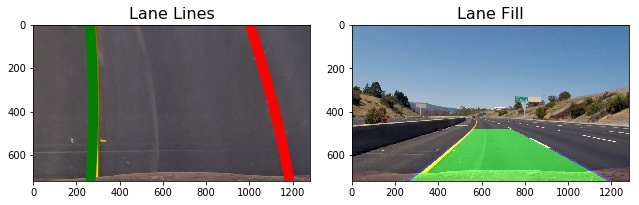

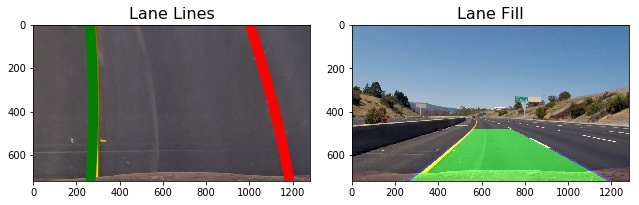

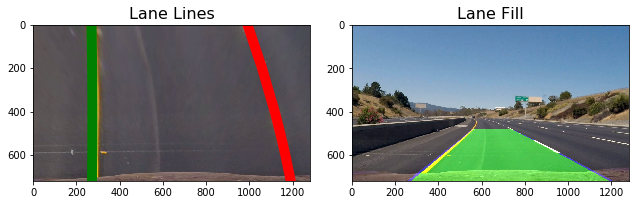

In [70]:
# debug with video images
test_files = ['dbg_frame_101.jpg', 'dbg_frame_102.jpg', 'dbg_frame_103.jpg' ]
for image in test_files:
    img1 = cv2.imread(image)
    warped = apply_transforms(img1)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    #plot3(img1, 'original', warped, 'warped image', histogram, 'histogram' )
    fill_lane(img1)